## Flood Impacts on Vulnerable Communities in New York City

**Part 1: Stephanie Andrade**

*In this notebook we will be analyzing data relevant to flood infrastructure and Census Data in New York City.*

**Are low income communities of color in New York City disproportionately affected by flood disasters?**


In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
Income = gpd.read_file('data/NYC Median Income.geojson')

In [3]:
Race = gpd.read_file('data/NYC Race.geojson')

**Quick Census data check.**

In [4]:
Income.shape

(2167, 5)

In [5]:
Race.shape

(2167, 45)

In [6]:
Income.head()

geoid                        name  B19013001  \
0  14000US36005000100   Census Tract 1, Bronx, NY        NaN   
1  14000US36005000200   Census Tract 2, Bronx, NY    51100.0   
2  14000US36005000400   Census Tract 4, Bronx, NY    78409.0   
3  14000US36005001600  Census Tract 16, Bronx, NY    34093.0   
4  14000US36005001900  Census Tract 19, Bronx, NY    45156.0   

   B19013001, Error                                           geometry  
0               NaN  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1           14133.0  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2           11642.0  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3            2370.0  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4            8158.0  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

In [7]:
Race.head()

geoid                        name  B03002001  \
0  14000US36005000100   Census Tract 1, Bronx, NY     6864.0   
1  14000US36005000200   Census Tract 2, Bronx, NY     4532.0   
2  14000US36005000400   Census Tract 4, Bronx, NY     5516.0   
3  14000US36005001600  Census Tract 16, Bronx, NY     5825.0   
4  14000US36005001900  Census Tract 19, Bronx, NY     3141.0   

   B03002001, Error  B03002002  B03002002, Error  B03002003  B03002003, Error  \
0             331.0     4457.0             313.0      603.0             172.0   
1             471.0     1088.0             270.0       33.0              29.0   
2             558.0     1855.0             473.0      387.0             174.0   
3             398.0     2373.0             392.0      213.0             122.0   
4             341.0     1427.0             225.0      340.0              96.0   

   B03002004  B03002004, Error  ...  B03002017, Error  B03002018  \
0     3601.0             296.0  ...              17.0      486.0   
1      920.0             277.0  ...              12.0      936.0   
2     1264.0             465.0  ...              17.0      880.0   
3     2021.0             374.0  ...              17.0     1079.0   
4      937.0             184.0  ...              12.0      967.0   

   B03002018, Error  B03002019  B03002019, Error  B03002020  B03002020, Error  \
0             147.0       68.0              56.0        0.0              17.0   
1             440.0      171.0             150.0       71.0             116.0   
2             365.0      215.0             169.0       50.0              58.0   
3             321.0      172.0             115.0      132.0             109.0   
4             217.0      156.0             109.0      127.0             103.0   

   B03002021  B03002021, Error  \
0       68.0              56.0   
1      100.0              96.0   
2      165.0             152.0   
3       40.0              49.0   
4       29.0              30.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...  

[5 rows x 45 columns]

**Now we have a better idea of our general datasets. There are a few columns that need some clean up.**

**Both of our datasets are in the same region!**

<AxesSubplot:>

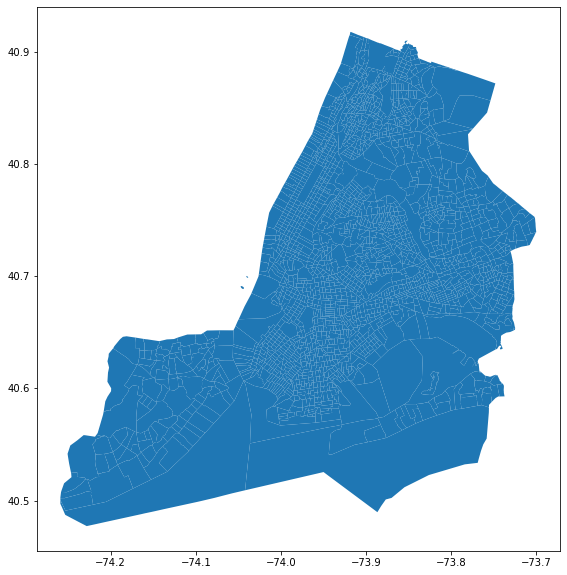

In [8]:
Race.plot(figsize=(10,10))

<AxesSubplot:>

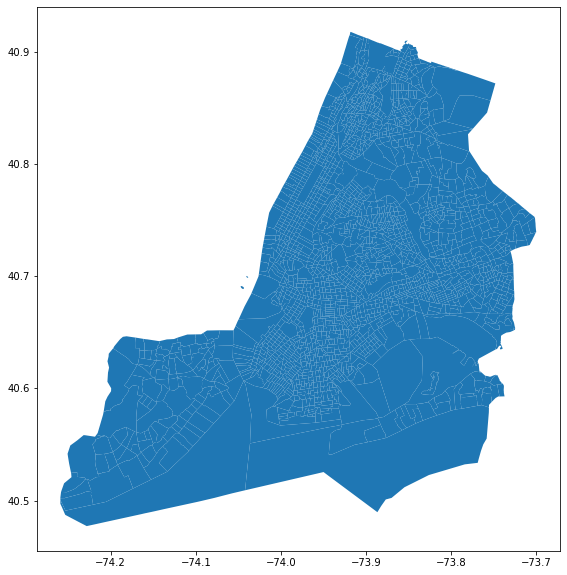

In [9]:
Income.plot(figsize=(10,10))

In [10]:
Income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2167 non-null   object  
 1   name              2167 non-null   object  
 2   B19013001         2095 non-null   float64 
 3   B19013001, Error  2090 non-null   float64 
 4   geometry          2167 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 84.8+ KB


In [11]:
Race.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2167 non-null   object  
 1   name              2167 non-null   object  
 2   B03002001         2167 non-null   float64 
 3   B03002001, Error  2167 non-null   float64 
 4   B03002002         2167 non-null   float64 
 5   B03002002, Error  2167 non-null   float64 
 6   B03002003         2167 non-null   float64 
 7   B03002003, Error  2167 non-null   float64 
 8   B03002004         2167 non-null   float64 
 9   B03002004, Error  2167 non-null   float64 
 10  B03002005         2167 non-null   float64 
 11  B03002005, Error  2167 non-null   float64 
 12  B03002006         2167 non-null   float64 
 13  B03002006, Error  2167 non-null   float64 
 14  B03002007         2167 non-null   float64 
 15  B03002007, Error  2167 non-null   float64 
 16  B03002008       

In [12]:
Income.geoid.head()

0    14000US36005000100
1    14000US36005000200
2    14000US36005000400
3    14000US36005001600
4    14000US36005001900
Name: geoid, dtype: object

In [13]:
Race.geoid.head()

0    14000US36005000100
1    14000US36005000200
2    14000US36005000400
3    14000US36005001600
4    14000US36005001900
Name: geoid, dtype: object

**Now we want clean up and delete all that unwanted data.**

In [14]:
list(Income)

['geoid', 'name', 'B19013001', 'B19013001, Error', 'geometry']

In [15]:
columns_to_keep_income = ['geoid','name','B19013001', 'geometry']

In [16]:
Income = Income[columns_to_keep_income]

In [17]:
Income.head()

geoid                        name  B19013001  \
0  14000US36005000100   Census Tract 1, Bronx, NY        NaN   
1  14000US36005000200   Census Tract 2, Bronx, NY    51100.0   
2  14000US36005000400   Census Tract 4, Bronx, NY    78409.0   
3  14000US36005001600  Census Tract 16, Bronx, NY    34093.0   
4  14000US36005001900  Census Tract 19, Bronx, NY    45156.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

In [18]:
list(Race)

['geoid',
 'name',
 'B03002001',
 'B03002001, Error',
 'B03002002',
 'B03002002, Error',
 'B03002003',
 'B03002003, Error',
 'B03002004',
 'B03002004, Error',
 'B03002005',
 'B03002005, Error',
 'B03002006',
 'B03002006, Error',
 'B03002007',
 'B03002007, Error',
 'B03002008',
 'B03002008, Error',
 'B03002009',
 'B03002009, Error',
 'B03002010',
 'B03002010, Error',
 'B03002011',
 'B03002011, Error',
 'B03002012',
 'B03002012, Error',
 'B03002013',
 'B03002013, Error',
 'B03002014',
 'B03002014, Error',
 'B03002015',
 'B03002015, Error',
 'B03002016',
 'B03002016, Error',
 'B03002017',
 'B03002017, Error',
 'B03002018',
 'B03002018, Error',
 'B03002019',
 'B03002019, Error',
 'B03002020',
 'B03002020, Error',
 'B03002021',
 'B03002021, Error',
 'geometry']

In [19]:
columns_to_keep_race = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']

In [20]:
Race = Race[columns_to_keep_race]

In [21]:
Race.head()

geoid                        name  B03002001  B03002002  \
0  14000US36005000100   Census Tract 1, Bronx, NY     6864.0     4457.0   
1  14000US36005000200   Census Tract 2, Bronx, NY     4532.0     1088.0   
2  14000US36005000400   Census Tract 4, Bronx, NY     5516.0     1855.0   
3  14000US36005001600  Census Tract 16, Bronx, NY     5825.0     2373.0   
4  14000US36005001900  Census Tract 19, Bronx, NY     3141.0     1427.0   

   B03002003  B03002004  B03002005  B03002006  B03002007  B03002008  \
0      603.0     3601.0       18.0      181.0        0.0       19.0   
1       33.0      920.0        0.0       75.0        0.0       60.0   
2      387.0     1264.0        0.0      121.0        0.0        9.0   
3      213.0     2021.0        0.0       64.0        0.0       50.0   
4      340.0      937.0        0.0       72.0        0.0       22.0   

   B03002009  B03002012                                           geometry  
0       35.0     2407.0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1        0.0     3444.0  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2       74.0     3661.0  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3       25.0     3452.0  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4       56.0     1714.0  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

**Renaming Columns**

In [22]:
list(Income)

['geoid', 'name', 'B19013001', 'geometry']

In [23]:
Income.columns = ['geoid', 'name', 'Median Income', 'geometry']

In [24]:
Income.head()

geoid                        name  Median Income  \
0  14000US36005000100   Census Tract 1, Bronx, NY            NaN   
1  14000US36005000200   Census Tract 2, Bronx, NY        51100.0   
2  14000US36005000400   Census Tract 4, Bronx, NY        78409.0   
3  14000US36005001600  Census Tract 16, Bronx, NY        34093.0   
4  14000US36005001900  Census Tract 19, Bronx, NY        45156.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

In [25]:
list(Race)

['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']

In [26]:
Race.columns = ['geoid', 'name', 
                  'Total',
                  'Non Hispanic or Latino',
                  'White',
                  'Black',
                  'American Indian and Alaska Native',
                  'Asian',
                  'Native Hawaiian and Other Pacific Islander',
                  'Non Hispanic Some other race',
                  'Non Hispanic Two or more races',
                  'Hispanic',
                  'geometry']
                  

In [27]:
Race.head()

geoid                        name   Total  \
0  14000US36005000100   Census Tract 1, Bronx, NY  6864.0   
1  14000US36005000200   Census Tract 2, Bronx, NY  4532.0   
2  14000US36005000400   Census Tract 4, Bronx, NY  5516.0   
3  14000US36005001600  Census Tract 16, Bronx, NY  5825.0   
4  14000US36005001900  Census Tract 19, Bronx, NY  3141.0   

   Non Hispanic or Latino  White   Black  American Indian and Alaska Native  \
0                  4457.0  603.0  3601.0                               18.0   
1                  1088.0   33.0   920.0                                0.0   
2                  1855.0  387.0  1264.0                                0.0   
3                  2373.0  213.0  2021.0                                0.0   
4                  1427.0  340.0   937.0                                0.0   

   Asian  Native Hawaiian and Other Pacific Islander  \
0  181.0                                         0.0   
1   75.0                                         0.0   
2  121.0                                         0.0   
3   64.0                                         0.0   
4   72.0                                         0.0   

   Non Hispanic Some other race  Non Hispanic Two or more races  Hispanic  \
0                          19.0                            35.0    2407.0   
1                          60.0                             0.0    3444.0   
2                           9.0                            74.0    3661.0   
3                          50.0                            25.0    3452.0   
4                          22.0                            56.0    1714.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

In [28]:
Race[Race['Total']==0]

geoid                              name  Total  \
63    14000US36005011000       Census Tract 110, Bronx, NY    0.0   
97    14000US36005016300       Census Tract 163, Bronx, NY    0.0   
103   14000US36005017100       Census Tract 171, Bronx, NY    0.0   
180   14000US36005024900       Census Tract 249, Bronx, NY    0.0   
337   14000US36005050400       Census Tract 504, Bronx, NY    0.0   
402   14000US36047008600        Census Tract 86, Kings, NY    0.0   
470   14000US36047017500       Census Tract 175, Kings, NY    0.0   
472   14000US36047017700       Census Tract 177, Kings, NY    0.0   
684   14000US36047040700       Census Tract 407, Kings, NY    0.0   
879   14000US36047066600       Census Tract 666, Kings, NY    0.0   
897   14000US36047070203    Census Tract 702.03, Kings, NY    0.0   
1011  14000US36047096000       Census Tract 960, Kings, NY    0.0   
1079  14000US36047118000      Census Tract 1180, Kings, NY    0.0   
1099  14000US36047990100      Census Tract 9901, Kings, NY    0.0   
1100  14000US36061000100      Census Tract 1, New York, NY    0.0   
1103  14000US36061000500      Census Tract 5, New York, NY    0.0   
1184  14000US36061008602  Census Tract 86.02, New York, NY    0.0   
1384  14000US36061031100    Census Tract 311, New York, NY    0.0   
1387  14000US36061031900    Census Tract 319, New York, NY    0.0   
1412  14000US36081003700       Census Tract 37, Queens, NY    0.0   
1455  14000US36081009900       Census Tract 99, Queens, NY    0.0   
1463  14000US36081010701   Census Tract 107.01, Queens, NY    0.0   
1552  14000US36081021900      Census Tract 219, Queens, NY    0.0   
1555  14000US36081022900      Census Tract 229, Queens, NY    0.0   
1564  14000US36081024600      Census Tract 246, Queens, NY    0.0   
1609  14000US36081029900      Census Tract 299, Queens, NY    0.0   
1620  14000US36081033100      Census Tract 331, Queens, NY    0.0   
1644  14000US36081038301   Census Tract 383.01, Queens, NY    0.0   
1645  14000US36081038302   Census Tract 383.02, Queens, NY    0.0   
1798  14000US36081061302   Census Tract 613.02, Queens, NY    0.0   
1808  14000US36081062400      Census Tract 624, Queens, NY    0.0   
1822  14000US36081064102   Census Tract 641.02, Queens, NY    0.0   
1827  14000US36081065501   Census Tract 655.01, Queens, NY    0.0   
1860  14000US36081071600      Census Tract 716, Queens, NY    0.0   
1891  14000US36081079300      Census Tract 793, Queens, NY    0.0   
1922  14000US36081091602   Census Tract 916.02, Queens, NY    0.0   
1954  14000US36081099900      Census Tract 999, Queens, NY    0.0   
1968  14000US36081107202  Census Tract 1072.02, Queens, NY    0.0   
2001  14000US36081121100     Census Tract 1211, Queens, NY    0.0   
2012  14000US36081128300     Census Tract 1283, Queens, NY    0.0   
2056  14000US36081990100     Census Tract 9901, Queens, NY    0.0   
2113  14000US36085015400    Census Tract 154, Richmond, NY    0.0   
2166  14000US36085990100   Census Tract 9901, Richmond, NY    0.0   

      Non Hispanic or Latino  White  Black  American Indian and Alaska Native  \
63                       0.0    0.0    0.0                                0.0   
97                       0.0    0.0    0.0                                0.0   
103                      0.0    0.0    0.0                                0.0   
180                      0.0    0.0    0.0                                0.0   
337                      0.0    0.0    0.0                                0.0   
402                      0.0    0.0    0.0                                0.0   
470                      0.0    0.0    0.0                                0.0   
472                      0.0    0.0    0.0                                0.0   
684                      0.0    0.0    0.0                                0.0   
879                      0.0    0.0    0.0                                0.0   
897                      0.0    0.0    0.0                                0.0   
1011      

In [29]:
Race_no_pop = Race[Race['Total']==0]

In [30]:
print('There are ' + str(len(Race_no_pop)) + ' census tracts with no people in them')

There are 43 census tracts with no people in them


In [31]:
Race_no_pop[['geoid','Total']]

geoid  Total
63    14000US36005011000    0.0
97    14000US36005016300    0.0
103   14000US36005017100    0.0
180   14000US36005024900    0.0
337   14000US36005050400    0.0
402   14000US36047008600    0.0
470   14000US36047017500    0.0
472   14000US36047017700    0.0
684   14000US36047040700    0.0
879   14000US36047066600    0.0
897   14000US36047070203    0.0
1011  14000US36047096000    0.0
1079  14000US36047118000    0.0
1099  14000US36047990100    0.0
1100  14000US36061000100    0.0
1103  14000US36061000500    0.0
1184  14000US36061008602    0.0
1384  14000US36061031100    0.0
1387  14000US36061031900    0.0
1412  14000US36081003700    0.0
1455  14000US36081009900    0.0
1463  14000US36081010701    0.0
1552  14000US36081021900    0.0
1555  14000US36081022900    0.0
1564  14000US36081024600    0.0
1609  14000US36081029900    0.0
1620  14000US36081033100    0.0
1644  14000US36081038301    0.0
1645  14000US36081038302    0.0
1798  14000US36081061302    0.0
1808  14000US36081062400    0.0
1822  14000US36081064102    0.0
1827  14000US36081065501    0.0
1860  14000US36081071600    0.0
1891  14000US36081079300    0.0
1922  14000US36081091602    0.0
1954  14000US36081099900    0.0
1968  14000US36081107202    0.0
2001  14000US36081121100    0.0
2012  14000US36081128300    0.0
2056  14000US36081990100    0.0
2113  14000US36085015400    0.0
2166  14000US36085990100    0.0

## Median Income Analysis

In [32]:
random_tract = Income.sample()
random_tract

geoid                         name  Median Income  \
236  14000US36005033500  Census Tract 335, Bronx, NY        96250.0   

                                              geometry  
236  MULTIPOLYGON (((-73.90906 40.88951, -73.90868 ...

<AxesSubplot:ylabel='Frequency'>

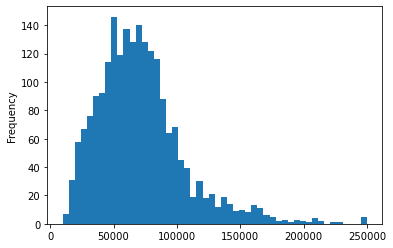

In [33]:
Income['Median Income'].plot.hist(bins=50)

In [34]:
Income['Median Income'].median()

66534.0

**Let us make this a little more visually appealing.**

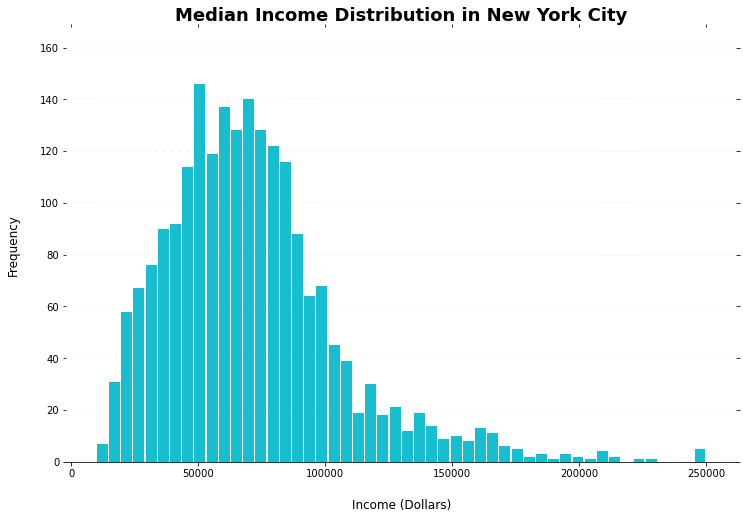

In [35]:
ax = Income.hist(column='Median Income', bins=50, grid=False, figsize=(12,8), color='#17becf', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:
    
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Median Income Distribution in New York City", weight='bold', size=18)

    # Set x-axis label
    x.set_xlabel("Income (Dollars)", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("Frequency", labelpad=20, size=12)

In [36]:
Income_sorted = Income.sort_values(by='Median Income',ascending = False)

In [37]:
Income_sorted[['geoid','Median Income']].head(10)

geoid  Median Income
1265  14000US36061016001       250001.0
1167  14000US36061006900       250001.0
1385  14000US36061031703       250001.0
1214  14000US36061011401       250001.0
1119  14000US36061002100       250001.0
351   14000US36047002100       228276.0
1133  14000US36061003300       223438.0
1253  14000US36061015002       214831.0
1223  14000US36061012200       211705.0
1159  14000US36061006100       210726.0

**The top earning counties in New York City.**

<AxesSubplot:>

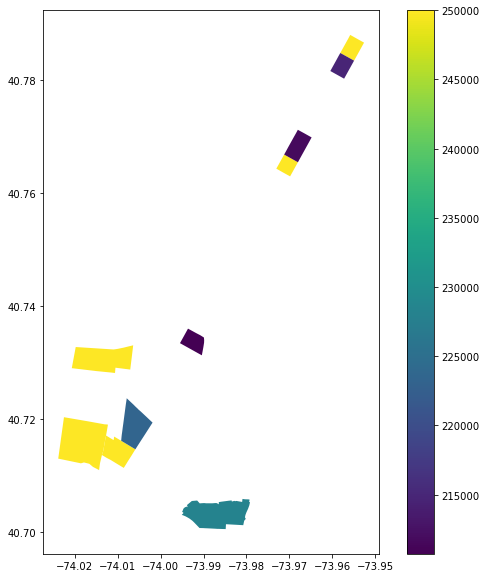

In [38]:
Income_sorted.head(10).plot(figsize=(10,10),column='Median Income',legend=True)

<AxesSubplot:>

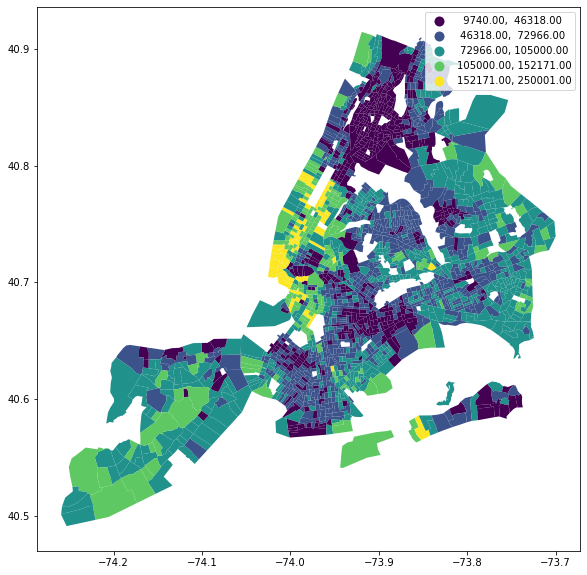

In [39]:
Income.plot(figsize=(12,10),
                 column='Median Income',
                 legend=True, 
                 scheme='NaturalBreaks')

<AxesSubplot:>

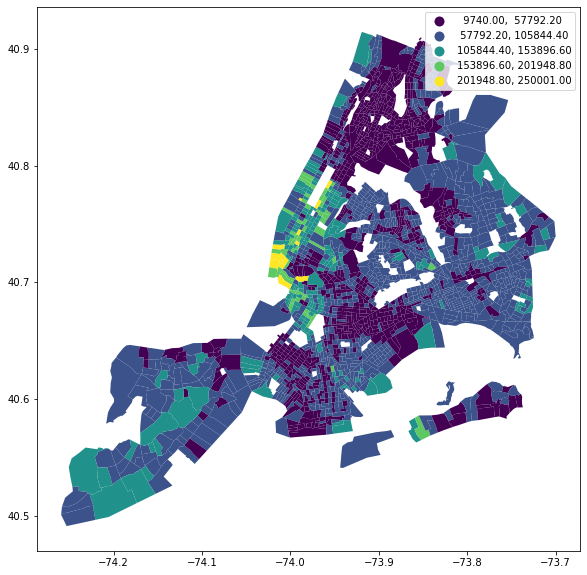

In [40]:
Income.plot(figsize=(12,10),
                 column='Median Income',
                 legend=True, 
                 scheme='equal_interval')

<AxesSubplot:>

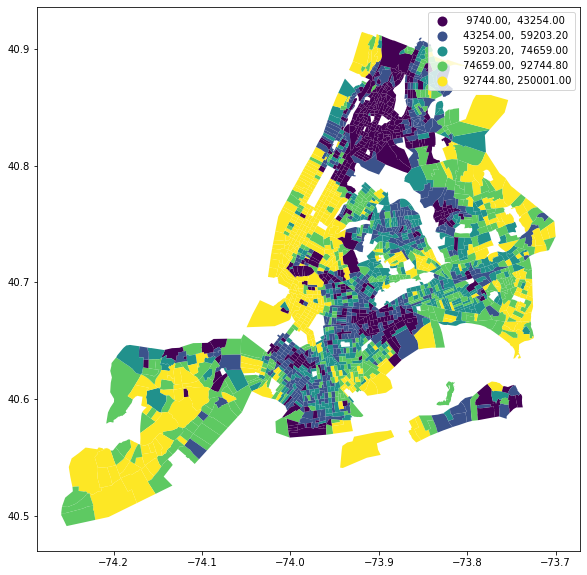

In [41]:
Income.plot(figsize=(12,10),
                 column='Median Income',
                 legend=True, 
                 scheme='quantiles')

<AxesSubplot:>

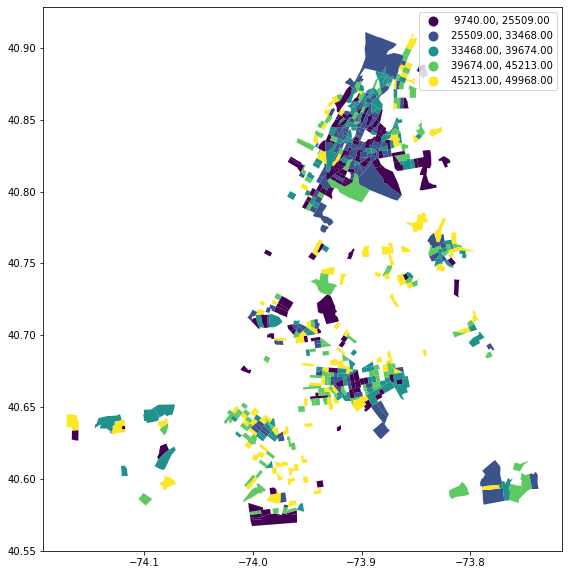

In [42]:
Income[Income['Median Income'] < 50000].plot(figsize=(12,10),column='Median Income',
                 legend=True, 
                 scheme='quantiles')

In [43]:
Income_web_mercator = Income.to_crs(epsg=3857)

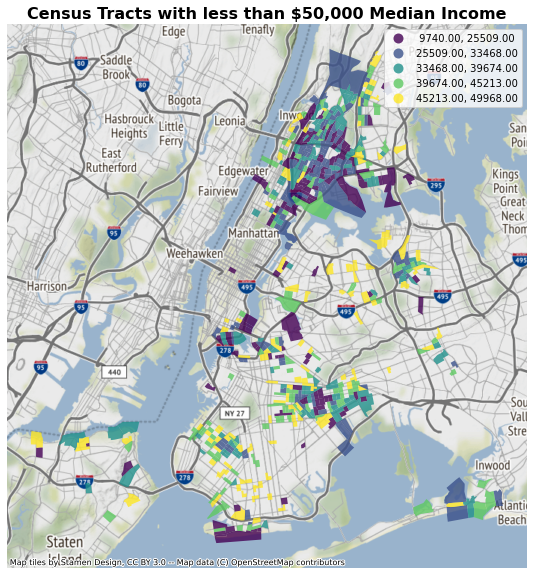

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

Income_web_mercator[Income_web_mercator['Median Income'] < 50000].plot(ax=ax, alpha=0.8, column='Median Income',
                 legend=True, 
                 scheme='quantiles')

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Census Tracts with less than $50,000 Median Income',fontsize=16, weight='bold')

# add a basemap
ctx.add_basemap(ax)

## Race Analysis

In [45]:
random_tract2 = Race.sample()
random_tract2

geoid                          name   Total  \
1051  14000US36047112000  Census Tract 1120, Kings, NY  3105.0   

      Non Hispanic or Latino  White   Black  \
1051                  1974.0   10.0  1905.0   

      American Indian and Alaska Native  Asian  \
1051                                0.0   59.0   

      Native Hawaiian and Other Pacific Islander  \
1051                                         0.0   

      Non Hispanic Some other race  Non Hispanic Two or more races  Hispanic  \
1051                           0.0                             0.0    1131.0   

                                               geometry  
1051  MULTIPOLYGON (((-73.88360 40.66790, -73.88278 ...

#### Race data includes a lot more columns so we need to make sure our clean up did not mess up our entire dataset.

In [46]:
random_tract2.iloc[0]['Total']

3105.0

In [47]:
print('Total population: ' + str(random_tract2.iloc[0]['Total']))

Total population: 3105.0


In [48]:
print('Non Hispanic or Latino + Hispanic: ' + str(random_tract2.iloc[0]['Non Hispanic or Latino'] + random_tract2.iloc[0]['Hispanic']))

Non Hispanic or Latino + Hispanic: 3105.0


In [49]:
Race.head()

geoid                        name   Total  \
0  14000US36005000100   Census Tract 1, Bronx, NY  6864.0   
1  14000US36005000200   Census Tract 2, Bronx, NY  4532.0   
2  14000US36005000400   Census Tract 4, Bronx, NY  5516.0   
3  14000US36005001600  Census Tract 16, Bronx, NY  5825.0   
4  14000US36005001900  Census Tract 19, Bronx, NY  3141.0   

   Non Hispanic or Latino  White   Black  American Indian and Alaska Native  \
0                  4457.0  603.0  3601.0                               18.0   
1                  1088.0   33.0   920.0                                0.0   
2                  1855.0  387.0  1264.0                                0.0   
3                  2373.0  213.0  2021.0                                0.0   
4                  1427.0  340.0   937.0                                0.0   

   Asian  Native Hawaiian and Other Pacific Islander  \
0  181.0                                         0.0   
1   75.0                                         0.0   
2  121.0                                         0.0   
3   64.0                                         0.0   
4   72.0                                         0.0   

   Non Hispanic Some other race  Non Hispanic Two or more races  Hispanic  \
0                          19.0                            35.0    2407.0   
1                          60.0                             0.0    3444.0   
2                           9.0                            74.0    3661.0   
3                          50.0                            25.0    3452.0   
4                          22.0                            56.0    1714.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...  
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...  
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...  
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...  
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...

In [50]:
print(random_tract2.iloc[0]['White'] + 
      random_tract2.iloc[0]['Black'] + 
      random_tract2.iloc[0]['American Indian and Alaska Native'] + 
      random_tract2.iloc[0]['Asian'] + 
      random_tract2.iloc[0]['Native Hawaiian and Other Pacific Islander'] + 
      random_tract2.iloc[0]['Non Hispanic Some other race'] + 
      random_tract2.iloc[0]['Non Hispanic Two or more races'] + 
      random_tract2.iloc[0]['Hispanic'])

3105.0


In [51]:
Race['Total'].head()

0    6864.0
1    4532.0
2    5516.0
3    5825.0
4    3141.0
Name: Total, dtype: float64

In [52]:
Race['Total'].mean()

3885.2404245500693

In [53]:
Race['Total'].median()

3537.0

In [54]:
Race['Total'].describe()

count     2167.000000
mean      3885.240425
std       2246.698805
min          0.000000
25%       2346.000000
50%       3537.000000
75%       4933.500000
max      28109.000000
Name: Total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

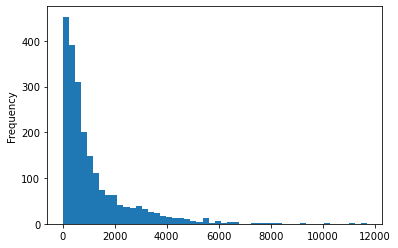

In [55]:
Race['Hispanic'].plot.hist(bins=50)

#### Let's create a cleaner histogram with x and y axis labels.

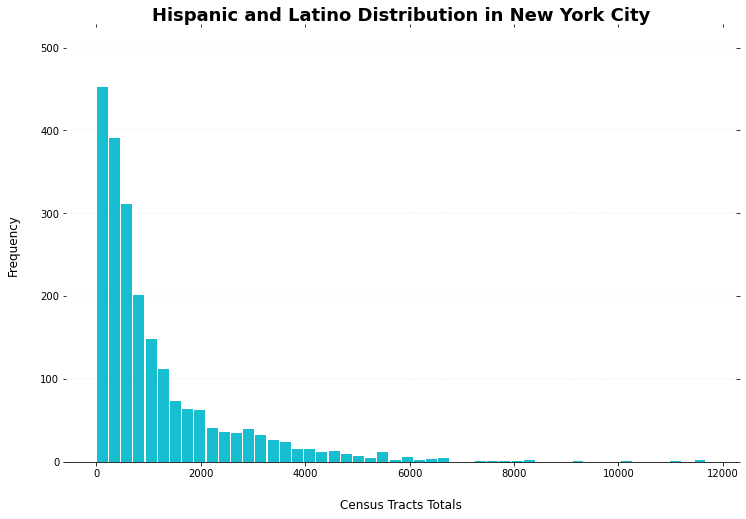

In [56]:
ax = Race.hist(column='Hispanic', bins=50, grid=False, figsize=(12,8), color='#17becf', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:
    
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Hispanic and Latino Distribution in New York City", weight='bold', size=18)

    # Set x-axis label
    x.set_xlabel("Census Tracts Totals", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("Frequency", labelpad=20, size=12)

In [57]:
list(Race)

['geoid',
 'name',
 'Total',
 'Non Hispanic or Latino',
 'White',
 'Black',
 'American Indian and Alaska Native',
 'Asian',
 'Native Hawaiian and Other Pacific Islander',
 'Non Hispanic Some other race',
 'Non Hispanic Two or more races',
 'Hispanic',
 'geometry']

In [58]:
Race['Percent Non Hispanic or Latino'] = Race['Non Hispanic or Latino']/Race['Total']*100

Race['Percent Hispanic'] = Race['Hispanic']/Race['Total']*100

Race['Percent White'] = Race['White']/Race['Total']*100

Race['Percent Black'] = Race['Black']/Race['Total']*100

Race['Percent American Indian and Alaska Native'] = Race['American Indian and Alaska Native']/Race['Total']*100

Race['Percent Asian'] = Race['Asian']/Race['Total']*100

Race['Percent Native Hawaiian and Other Pacific Islander'] = Race['Native Hawaiian and Other Pacific Islander']/Race['Total']*100

Race['Percent Non Hispanic Some other race'] = Race['Non Hispanic Some other race']/Race['Total']*100

Race['Percent Non Hispanic Two or more races'] = Race['Non Hispanic Two or more races']/Race['Total']*100

In [59]:
Race.head(5)

geoid                        name   Total  \
0  14000US36005000100   Census Tract 1, Bronx, NY  6864.0   
1  14000US36005000200   Census Tract 2, Bronx, NY  4532.0   
2  14000US36005000400   Census Tract 4, Bronx, NY  5516.0   
3  14000US36005001600  Census Tract 16, Bronx, NY  5825.0   
4  14000US36005001900  Census Tract 19, Bronx, NY  3141.0   

   Non Hispanic or Latino  White   Black  American Indian and Alaska Native  \
0                  4457.0  603.0  3601.0                               18.0   
1                  1088.0   33.0   920.0                                0.0   
2                  1855.0  387.0  1264.0                                0.0   
3                  2373.0  213.0  2021.0                                0.0   
4                  1427.0  340.0   937.0                                0.0   

   Asian  Native Hawaiian and Other Pacific Islander  \
0  181.0                                         0.0   
1   75.0                                         0.0   
2  121.0                                         0.0   
3   64.0                                         0.0   
4   72.0                                         0.0   

   Non Hispanic Some other race  ...  \
0                          19.0  ...   
1                          60.0  ...   
2                           9.0  ...   
3                          50.0  ...   
4                          22.0  ...   

                                            geometry  \
0  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
1  MULTIPOLYGON (((-73.86522 40.81453, -73.86425 ...   
2  MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...   
3  MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...   
4  MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...   

   Percent Non Hispanic or Latino Percent Hispanic  Percent White  \
0                       64.932984        35.067016       8.784965   
1                       24.007061        75.992939       0.728155   
2                       33.629442        66.370558       7.015954   
3                       40.738197        59.261803       3.656652   
4                       45.431391        54.568609      10.824578   

   Percent Black  Percent American Indian and Alaska Native  Percent Asian  \
0      52.462121                                   0.262238       2.636946   
1      20.300088                                   0.000000       1.654898   
2      22.915156                                   0.000000       2.193619   
3      34.695279                                   0.000000       1.098712   
4      29.831264                                   0.000000       2.292264   

   Percent Native Hawaiian and Other Pacific Islander  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   Percent Non Hispanic Some other race  \
0                              0.276807   
1                              1.323919   
2                              0.163162   
3                              0.858369   
4                              0.700414   

   Percent Non Hispanic Two or more races  
0                                0.509907  
1                                0.000000  
2                                1.341552  
3                                0.429185  
4                                1.782872  

[5 rows x 22 columns]

<AxesSubplot:>

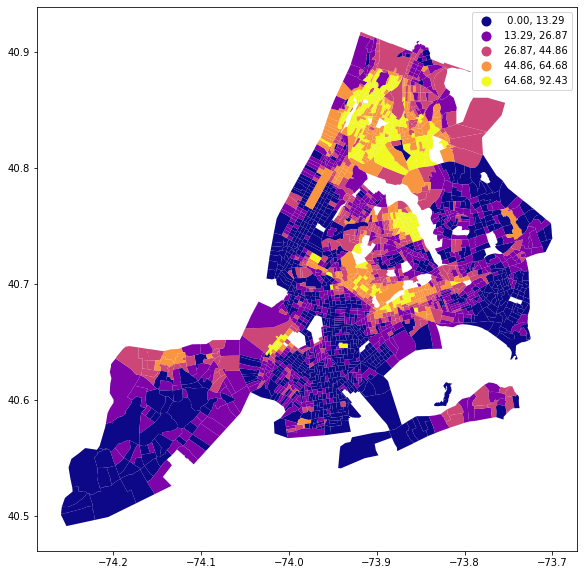

In [60]:
Race.plot(figsize=(12,10),
                 column='Percent Hispanic',
                  cmap='plasma',
                 legend=True, 
                 scheme='NaturalBreaks')

<AxesSubplot:>

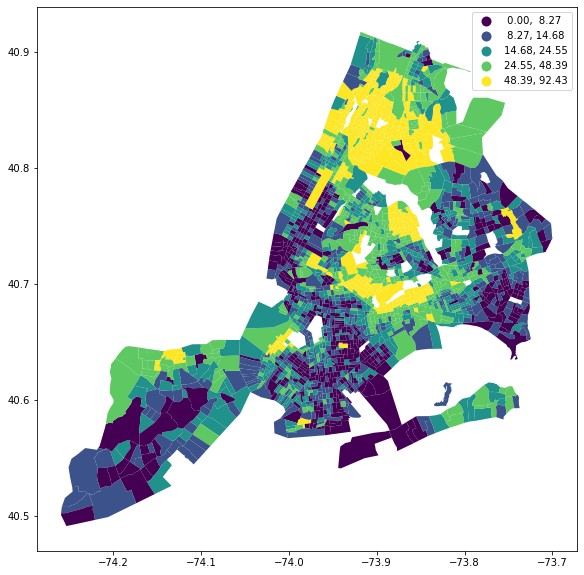

In [61]:
Race.plot(figsize=(12,10),
                 column='Percent Hispanic',
                 legend=True, 
                 scheme='Quantiles')

<AxesSubplot:>

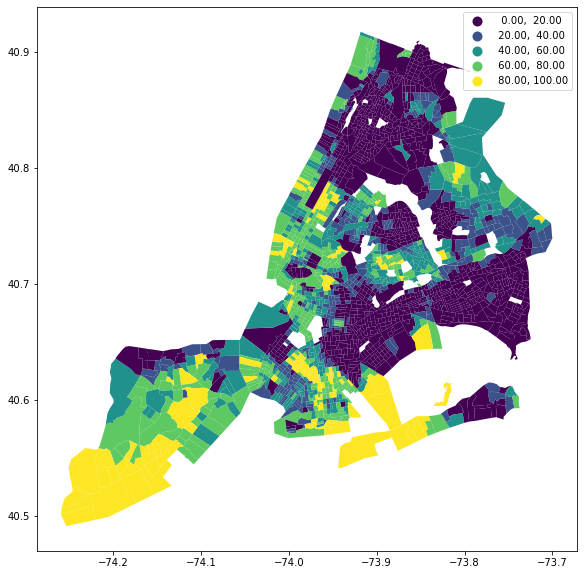

In [62]:
Race.plot(figsize=(12,10),
                 column='Percent White',
                 legend=True, 
                 scheme='equal_interval')

<AxesSubplot:>

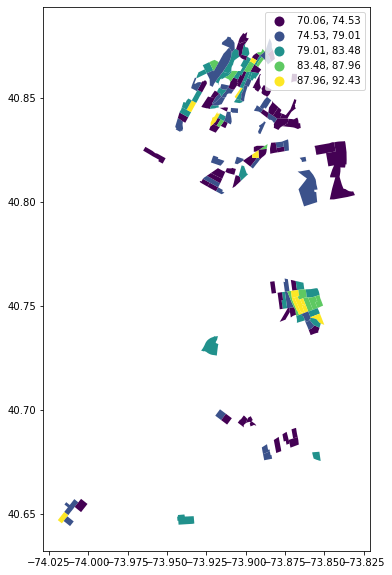

In [63]:
Race[Race['Percent Hispanic'] > 70].plot(figsize=(12,10),column='Percent Hispanic',
                 legend=True, 
                 scheme='equal_interval')

<AxesSubplot:>

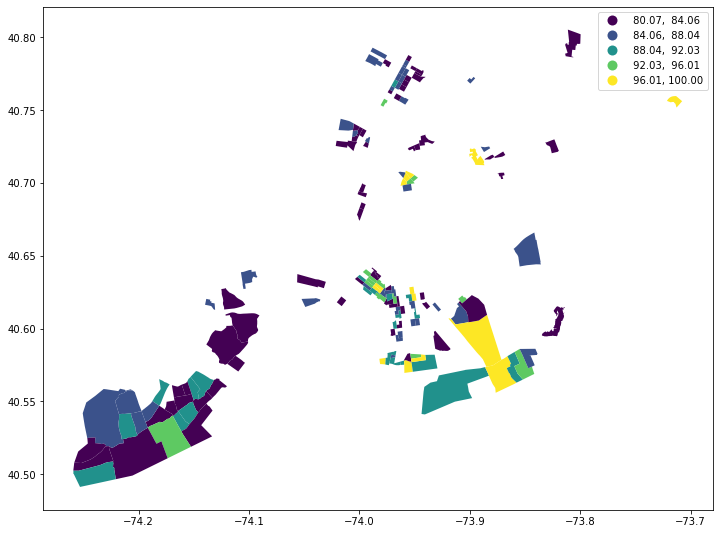

In [64]:
Race[Race['Percent White'] > 80].plot(figsize=(12,10),column='Percent White',
                 legend=True, 
                 scheme='equal_interval')

In [65]:
Race_web_mercator = Race.to_crs(epsg=3857)

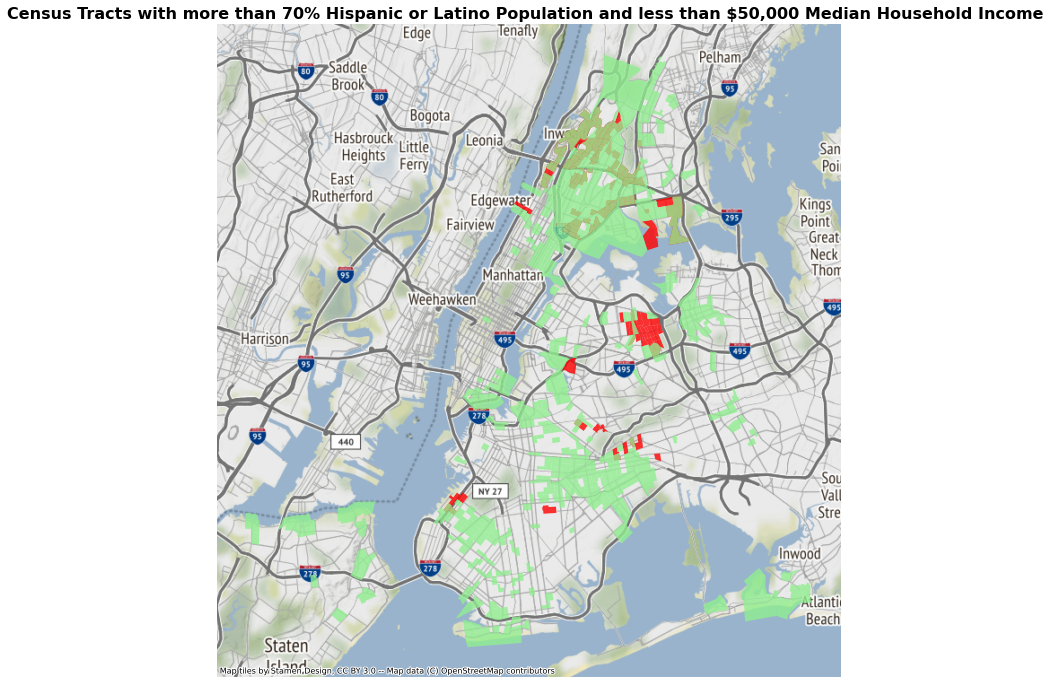

In [77]:
fig, ax = plt.subplots(figsize=(12, 12))

Race_web_mercator[Race_web_mercator['Percent Hispanic'] > 70].plot(ax=ax, alpha=0.8, color='red')
Income_web_mercator[Income_web_mercator['Median Income'] < 50000].plot(ax=ax, alpha=0.8, color='lightgreen')

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Census Tracts with more than 70% Hispanic or Latino Population and less than $50,000 Median Household Income ',fontsize=16, weight='bold')

# add a basemap
ctx.add_basemap(ax)

## Week 7 Additional Code

**Included in this lab is a Function. This helps us run data faster and allows us to see multiple maps using fewer codes.**

**Below there is a brief analysis of distribution of multiple race groups in our dataset. It is interesting to see the distribution of each population and the distinction between white areas vs nonwhite.**

In [67]:
def race_data(column_name, scheme):
    Race.plot(figsize=(12,10),cmap='plasma',
                 column=column_name,
                 legend=True, 
                 scheme=scheme)
    plt.title(column_name)

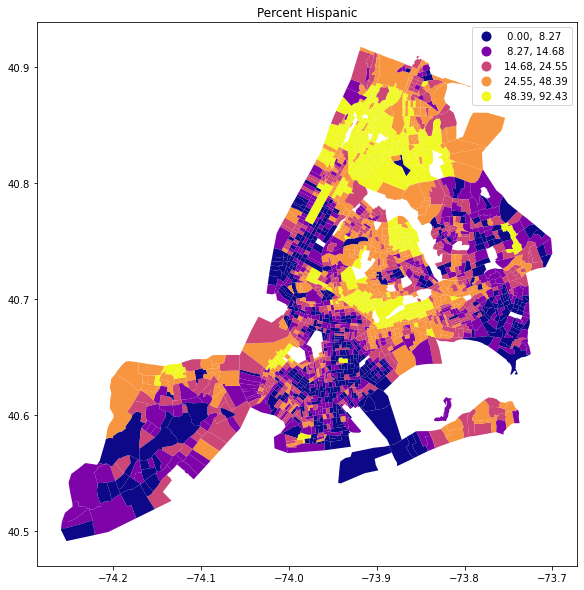

In [68]:
race_data(column_name='Percent Hispanic', scheme='Quantiles')

In [69]:
loop_columns = ['Percent Non Hispanic or Latino',
 'Percent Hispanic',
 'Percent White',
 'Percent Black',
 'Percent American Indian and Alaska Native',
 'Percent Native Hawaiian and Other Pacific Islander',
 'Percent Non Hispanic Some other race',
 'Percent Non Hispanic Two or more races']

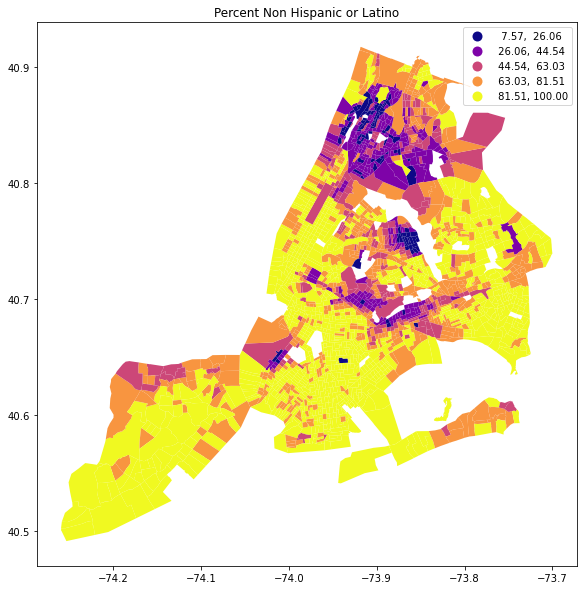

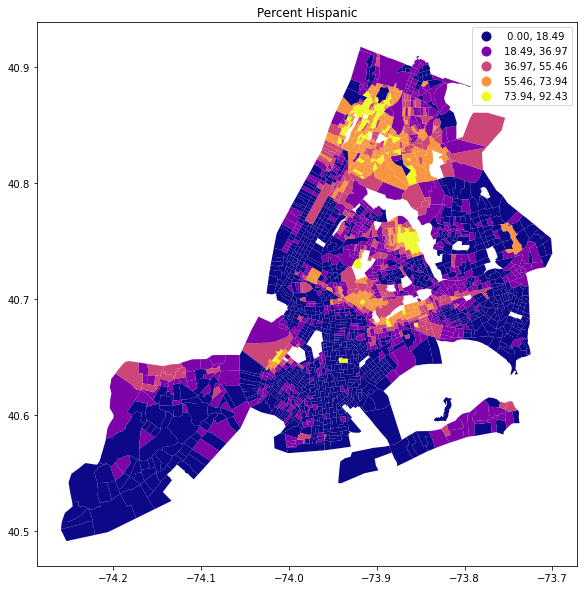

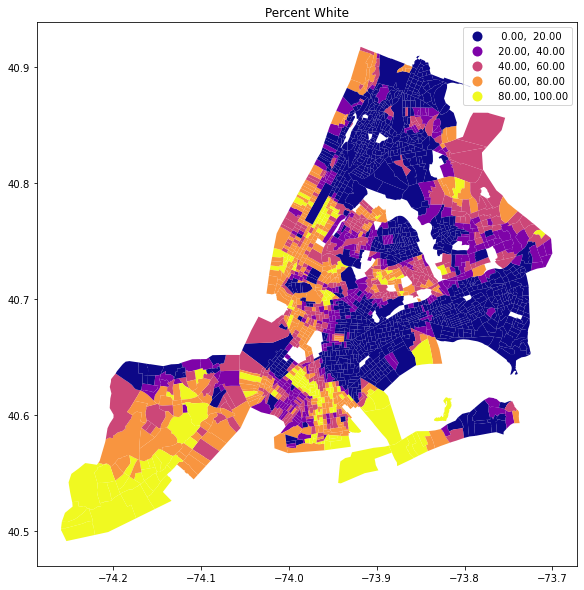

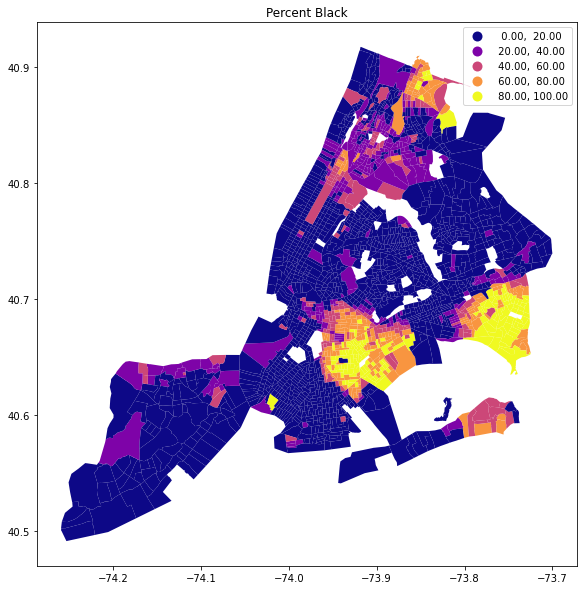

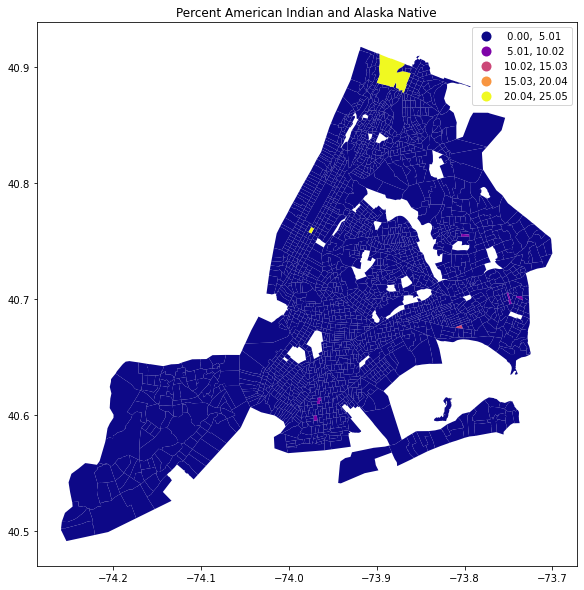

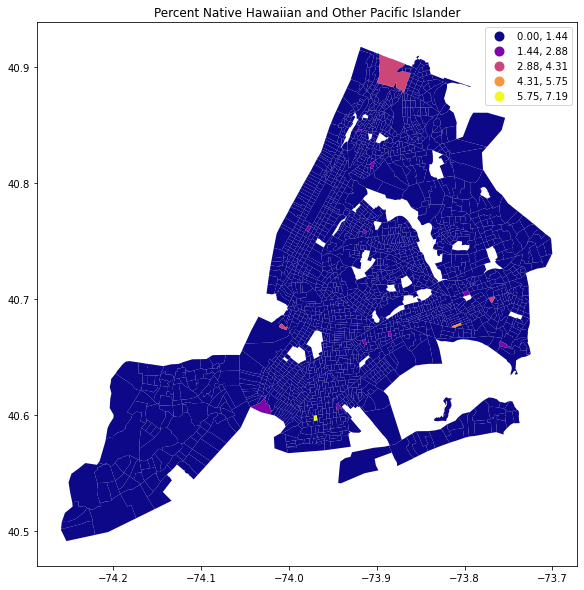

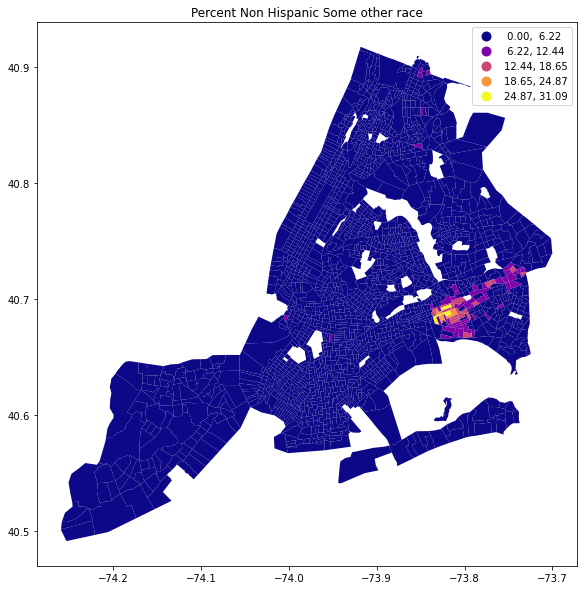

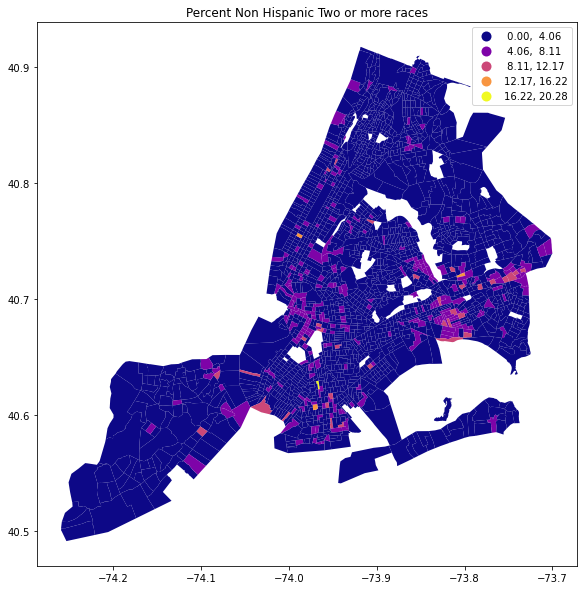

In [70]:
for column in loop_columns:
    race_data(column, scheme = 'equal_interval')

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


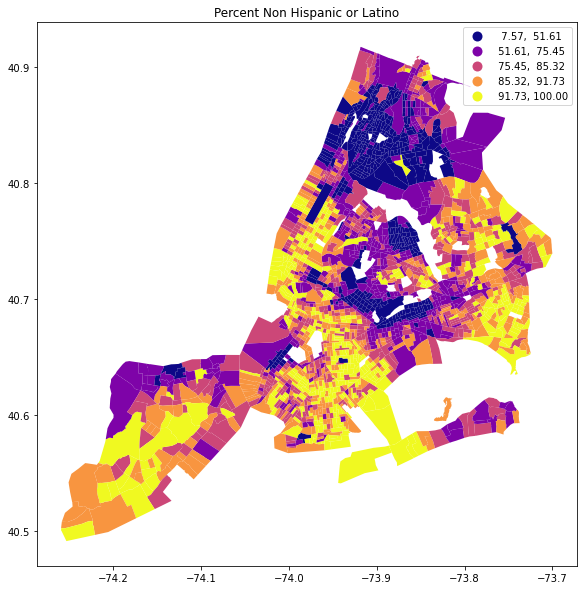

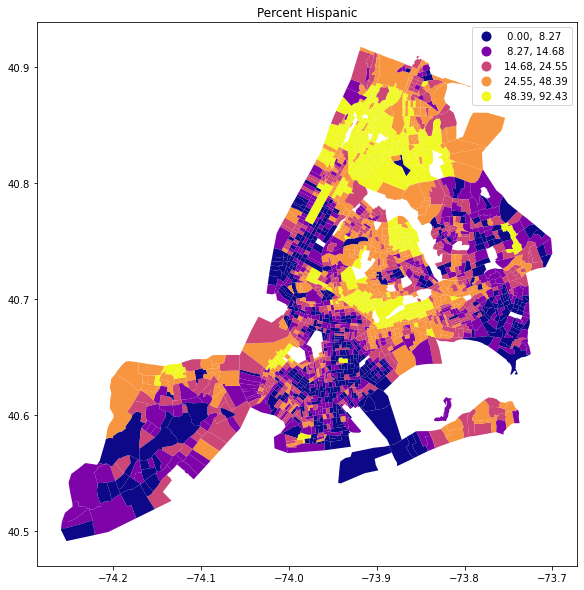

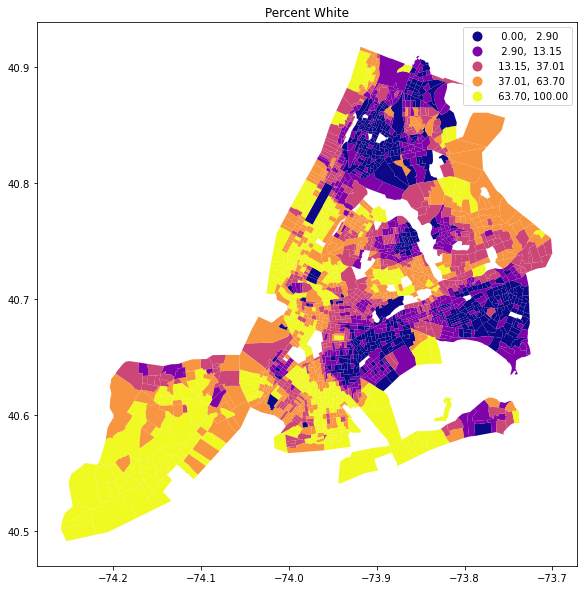

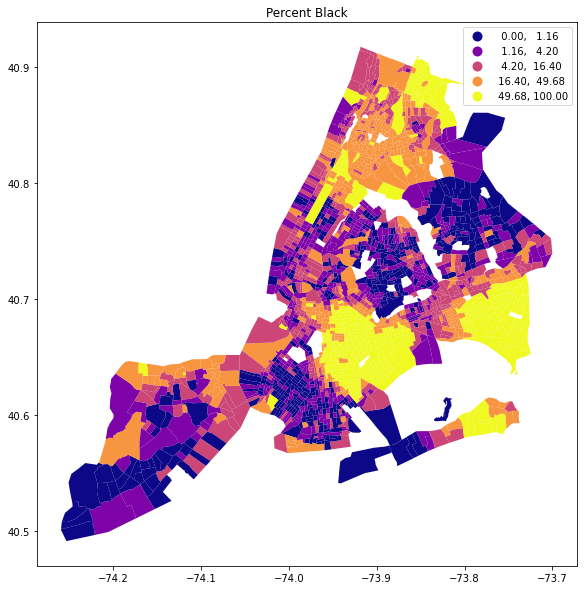

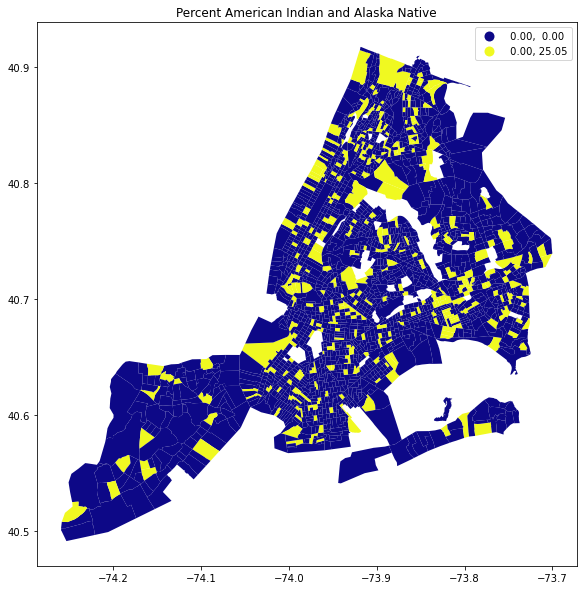

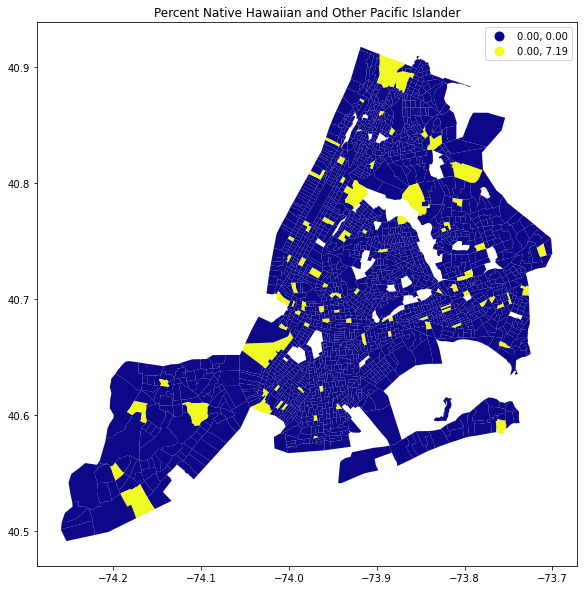

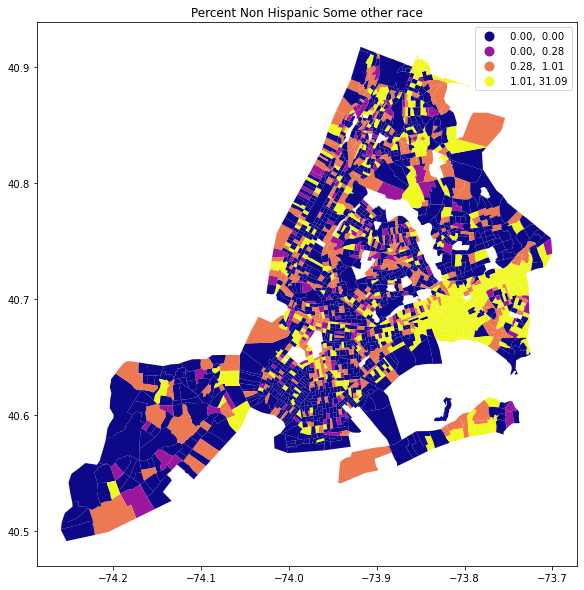

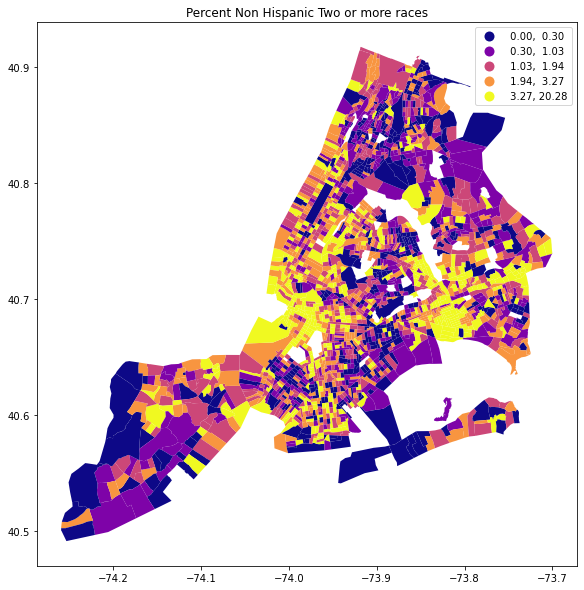

In [71]:
for column in loop_columns:
    race_data(column, scheme = 'quantiles')

## Overlapping Flood Zones and Census Data

In [72]:
flood = gpd.read_file('data/100 year Floodplain.geojson')

In [73]:
flood = flood.to_crs(epsg=3857)

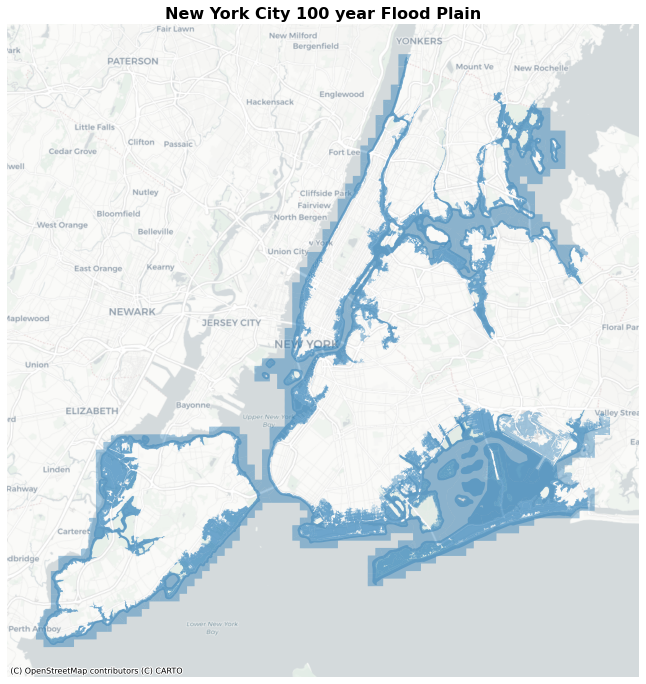

In [74]:
fig, ax = plt.subplots(figsize=(12,12))

flood.plot(ax=ax,
         lw=0.5,
         alpha=0.4)

ax.set_title('New York City 100 year Flood Plain',fontsize=16, weight='bold')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

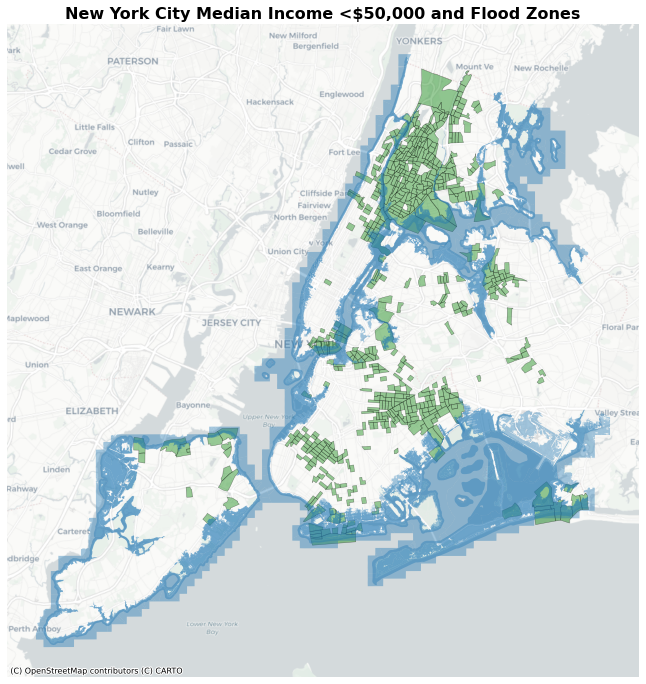

In [75]:
fig, ax = plt.subplots(figsize=(12,12))

Income_web_mercator[Income_web_mercator['Median Income'] < 50000].plot(ax=ax, 
                                                                       edgecolor='black',
                                                                         lw=0.5,
                                                                       alpha=0.4, 
                                                                       color='green')
flood.plot(ax=ax,
         lw=0.5,
         alpha=0.4)
ax.set_title('New York City Median Income <$50,000 and Flood Zones',fontsize=16, weight='bold')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


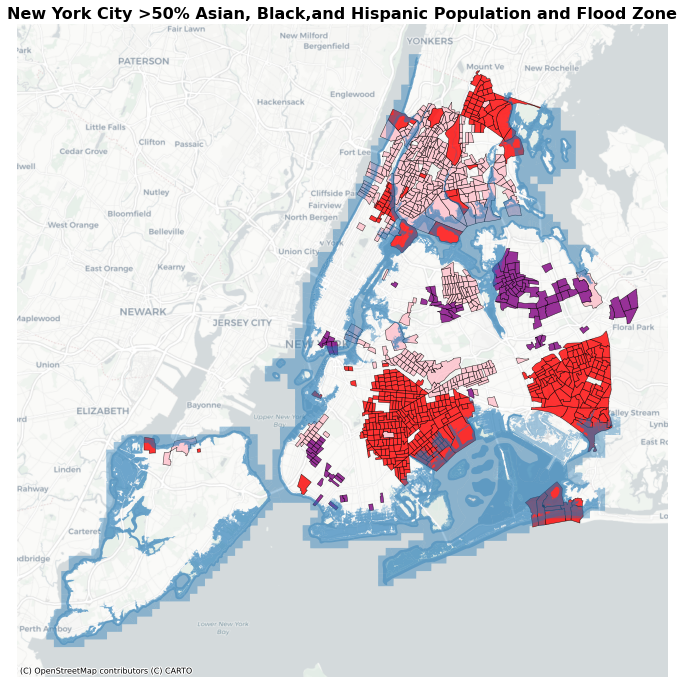

In [76]:
fig, ax = plt.subplots(figsize=(12,12))

Race_web_mercator[Race_web_mercator['Percent Hispanic'] > 50].plot(ax=ax, 
                                                                   edgecolor='black',
                                                                    lw=0.5, alpha=0.8, 
                                                                   color='pink')
Race_web_mercator[Race_web_mercator['Percent Black'] > 50].plot(ax=ax, 
                                                                   edgecolor='black',
                                                                    lw=0.5, alpha=0.8, 
                                                                   color='red')
Race_web_mercator[Race_web_mercator['Percent Asian'] > 50].plot(ax=ax, 
                                                                   edgecolor='black',
                                                                    lw=0.5, alpha=0.8, 
                                                                   color='purple')
Race_web_mercator[Race_web_mercator['Percent American Indian and Alaska Native'] > 50].plot(ax=ax, 
                                                                   edgecolor='black',
                                                                    lw=0.5, alpha=0.8, 
                                                                   color='yellow',)
Race_web_mercator[Race_web_mercator['Percent Native Hawaiian and Other Pacific Islander'] > 50].plot(ax=ax, 
                                                                   edgecolor='black',
                                                                    lw=0.5, alpha=0.8, 
                                                                   color='orange')
ax.set_title('New York City >50% Asian, Black,and Hispanic Population and Flood Zone',fontsize=16, weight='bold')
flood.plot(ax=ax,
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)